In [14]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import joblib

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# For reproducibility
np.random.seed(42)

In [15]:
# Load the project dataset
from prep import preprocess_data

train_df = pd.read_csv('./apache/train_labeled.csv')
test_df = pd.read_csv('./apache/test_labeled.csv')

train_df = preprocess_data(train_df, compact=True)
test_df = preprocess_data(test_df, compact=True)

# check if the columns are the same
if set(train_df.columns) != set(test_df.columns):
    print("Warning: Train and test datasets have different columns.")
    # Print the differences
    train_columns = set(train_df.columns)
    test_columns = set(test_df.columns)
    # get the columns that are in train but not in test
    train_only = train_columns - test_columns
    # get the columns that are in test but not in train
    test_only = test_columns - train_columns
    if train_only:
        print(f"Columns in train but not in test: {train_only}")
    if test_only:
        print(f"Columns in test but not in train: {test_only}")

In [16]:
# Encode 'project_category' using data from train_df
oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_encoded = oe.fit_transform(train_df[['project_category']])
test_encoded = oe.transform(test_df[['project_category']])
# Create DataFrames for the encoded categories
train_encoded_df = pd.DataFrame(train_encoded, columns=oe.get_feature_names_out(['project_category']))
test_encoded_df = pd.DataFrame(test_encoded, columns=oe.get_feature_names_out(['project_category']))
# Concatenate the encoded DataFrames with the original DataFrames
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [17]:
# useful columns derived from feature engineering
top_risk_predictors = pd.read_csv('./apache/top_risk_predictors.csv')
schedule_features = top_risk_predictors['Schedule Risk Predictors'].tolist()
quality_features = top_risk_predictors['Quality Risk Predictors'].tolist()

# Filter the DataFrame to keep only the top predictors (plus 'project_category' and the target variable)
schedule_train_df = train_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_train_df = train_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

schedule_test_df = test_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_test_df = test_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

In [18]:
# target = 'schedule_risk'
target = 'quality_risk'
target_names = ['Low Risk', 'High Risk']

if target == 'schedule_risk':
    train_df = schedule_train_df
    test_df = schedule_test_df
    features = schedule_features
elif target == 'quality_risk':
    train_df = quality_train_df
    test_df = quality_test_df
    features = quality_features

In [19]:
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
baseline_svm = svm.SVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced')
baseline_svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred_baseline = baseline_svm.predict(X_test_scaled)

# Evaluate the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

# Classification report
print("Classification Report for Baseline Model:")
print(classification_report(y_test, y_pred_baseline))

Baseline Model Accuracy: 0.8790
Classification Report for Baseline Model:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91        90
           1       0.70      0.97      0.81        34

    accuracy                           0.88       124
   macro avg       0.84      0.91      0.86       124
weighted avg       0.91      0.88      0.88       124



In [21]:
# Perform k-fold cross-validation
n_folds = 5
cv_scores = cross_val_score(baseline_svm, X_train_scaled, y_train, cv=n_folds, scoring='accuracy')
print(f"\nCross-Validation Scores (k={n_folds}): {cv_scores}")
print(f"Cross-Validation Accuracy (mean ± std): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-Validation Scores (k=5): [0.90909091 0.85858586 0.79591837 0.8877551  0.80612245]
Cross-Validation Accuracy (mean ± std): 0.8515 ± 0.0443


In [22]:
# Hyperparameter tuning

param_grid = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    'kernel': ['rbf', 'linear']
}

svm_model = svm.SVC(class_weight='balanced', random_state=42, probability=True)
grid_search = GridSearchCV(
    svm_model, 
    param_grid, 
    cv=n_folds, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Get the best model
best_svm_model = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8657



Best SVM Test Accuracy: 0.9355
Improvement over baseline: 5.65%

Classification Report (Best Model):
              precision    recall  f1-score   support

    Low Risk       0.98      0.93      0.95        90
   High Risk       0.84      0.94      0.89        34

    accuracy                           0.94       124
   macro avg       0.91      0.94      0.92       124
weighted avg       0.94      0.94      0.94       124



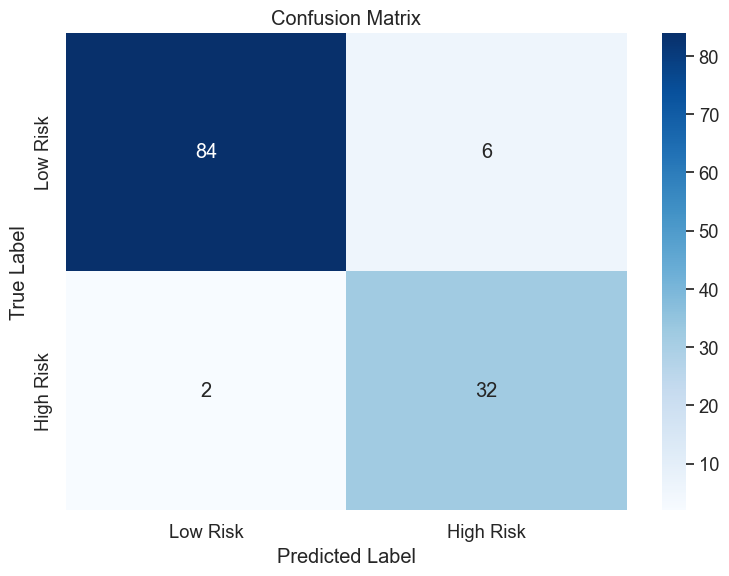

In [10]:
# 7. Model Evaluation with Best Model

# Make predictions on the test set using the best model
y_pred = best_svm_model.predict(X_test_scaled)

# Calculate accuracy
best_accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest SVM Test Accuracy: {best_accuracy:.4f}")

# Calculate if there was an improvement over baseline
improvement = (best_accuracy - baseline_accuracy) * 100
print(f"Improvement over baseline: {improvement:.2f}%")

# Display classification report for the best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred, target_names=target_names))

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [11]:
# Make probability predictions (need to set probability=True)
best_svm_prob = svm.SVC(probability=True, random_state=42, **grid_search.best_params_)
best_svm_prob.fit(X_train_scaled, y_train)

# Get probability predictions
y_proba = best_svm_prob.predict_proba(X_test_scaled)

# Display probability predictions for the first few samples
prob_df = pd.DataFrame(y_proba, columns=target_names)
prob_df['True Class'] = [target_names[i] for i in y_test]
prob_df['Predicted Class'] = [target_names[i] for i in best_svm_prob.predict(X_test_scaled)]
print("\nProbability predictions for the first 5 test samples:")
print(prob_df.head())


Probability predictions for the first 5 test samples:
   Low Risk  High Risk True Class Predicted Class
0  0.996390   0.003610   Low Risk        Low Risk
1  0.000002   0.999998  High Risk       High Risk
2  0.185944   0.814056  High Risk       High Risk
3  0.998692   0.001308   Low Risk        Low Risk
4  0.410807   0.589193  High Risk       High Risk


In [12]:
# 8. Support Vector Analysis

# Get support vectors
support_vectors = best_svm_model.support_vectors_
n_support = best_svm_model.n_support_

print(f"\nNumber of support vectors for each class: {n_support}")
print(f"Total number of support vectors: {sum(n_support)}")

# Display the first few support vectors
print("\nExample support vectors:")
print(support_vectors[:5])


Number of support vectors for each class: [137  64]
Total number of support vectors: 201

Example support vectors:
[[-0.22527506 -0.22689587 -0.08557167 -0.54057307  3.7222397   0.57909836
   0.47559865 -0.16186865  5.83092408 -1.76836488 -0.50311443 -0.2763585
  -0.20662348  0.7294338  -0.37421447 -0.3866946  -0.37971838 -0.13650473
  -0.12013738 -0.09053575 -0.20042239 -0.06388766 -0.07832604 -0.46024196
  -0.10132591 -0.39361095  3.40813506 -0.15811388 -0.16474184 -0.17733173
  -0.28097574 -0.3363364 ]
 [ 1.65685482 -1.02744011 -0.0856127  -0.47498533 -0.6470341  -0.28614248
  -0.86464459 -0.36343381 -0.63220166  0.04501213  0.81198743 -0.28054367
  -0.20662348 -0.0297966   1.44629718 -0.3866946  -0.37971838 -0.13650473
   8.32380408 -0.09053575 -0.20042239 -0.06388766 -0.07832604 -0.46024196
  -0.10132591 -0.39361095 -0.2934156  -0.15811388 -0.16474184 -0.17733173
  -0.28097574 -0.3363364 ]
 [-0.03913695 -0.17734125 -0.08557517 -0.30828507 -0.3575956   2.17608573
   0.43281435  0.

In [13]:
# 9. Dimension Reduction for Visualization

# Apply PCA for dimensionality reduction to visualize the data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate the variance explained by each principal component
ex_variance = np.var(X_train_pca, axis=0) / np.sum(np.var(X_train_scaled, axis=0))
print(f"\nVariance explained by the first two principal components: {ex_variance.sum():.2f}")
print(f"Variance ratio for PC1: {ex_variance[0]:.2f}, PC2: {ex_variance[1]:.2f}")


Variance explained by the first two principal components: 0.15
Variance ratio for PC1: 0.08, PC2: 0.07


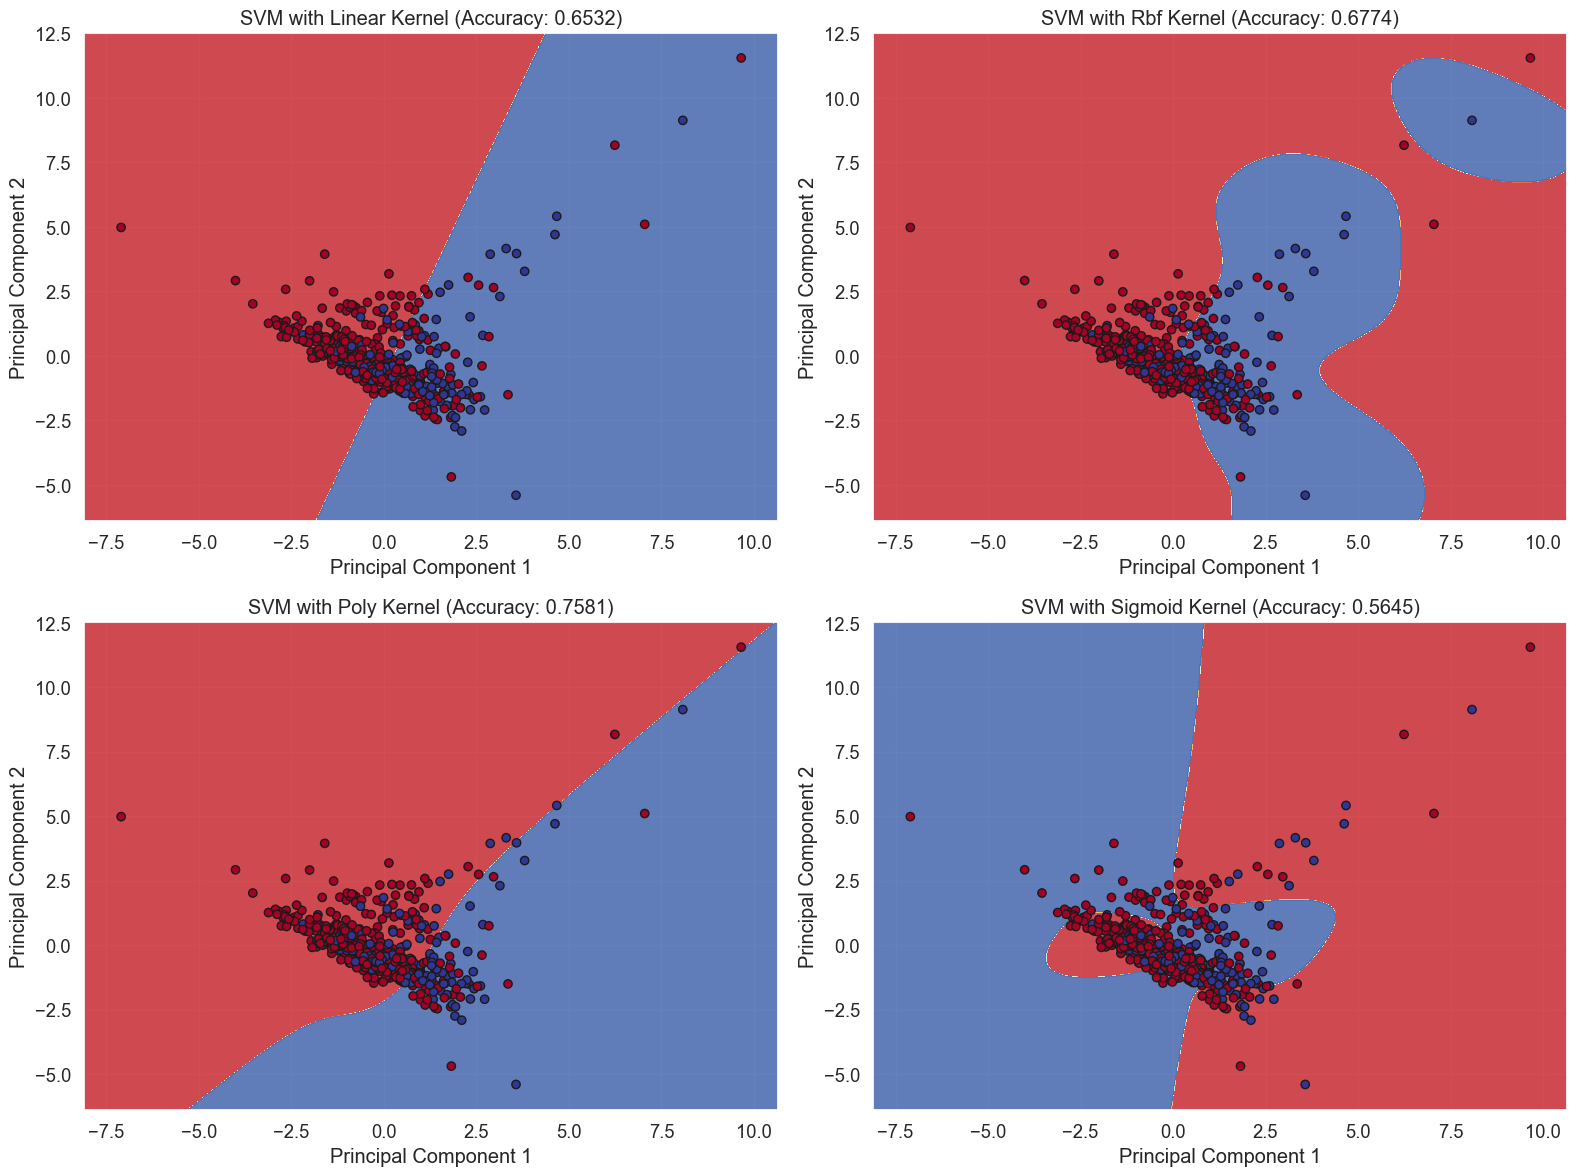

In [14]:
# 10. Decision Boundary Visualization

def plot_decision_boundary(clf, X, y, title='Decision Boundary'):
    # Set min and max values with some margin
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Predict for all grid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and points
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)

# Train SVM models with different kernels on the PCA-transformed data
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Create a 2x2 subplot grid to compare different kernels
plt.figure(figsize=(16, 12))

for i, kernel in enumerate(kernels):
    # Train SVM model with the specific kernel
    model = svm.SVC(kernel=kernel, random_state=42, class_weight='balanced')
    model.fit(X_train_pca, y_train)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, model.predict(X_test_pca))
    
    # Plot the decision boundary
    plt.subplot(2, 2, i+1)
    plot_decision_boundary(model, X_train_pca, y_train, 
                        title=f'SVM with {kernel.capitalize()} Kernel (Accuracy: {accuracy:.4f})')

plt.tight_layout()
plt.show()

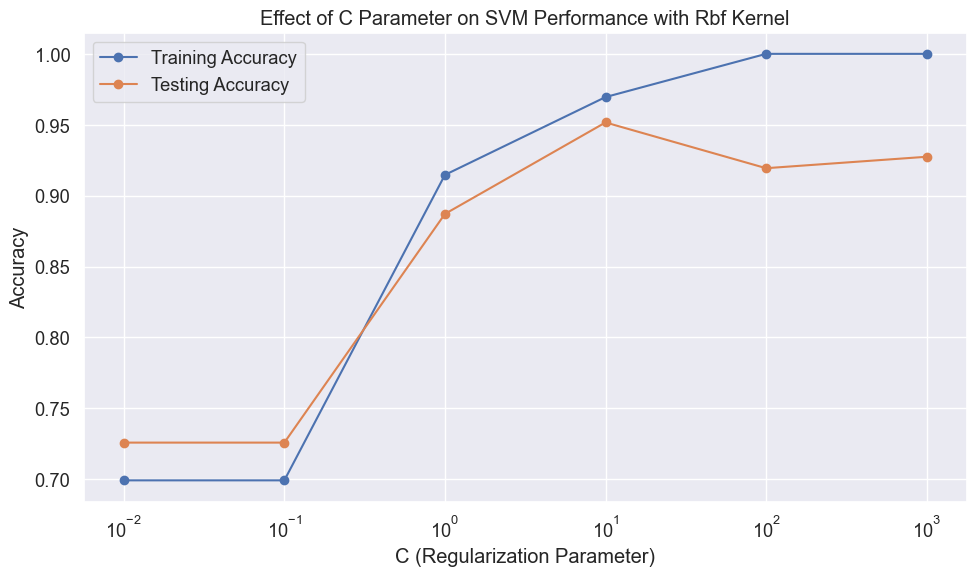

In [15]:
# 11. Hyperparameter Influence Analysis

# Analyze the effect of the C parameter (regularization) on model performance
C_values = [0.01, 0.1, 1, 10, 100, 1000]
accuracies_train = []
accuracies_test = []

# Use the best kernel from grid search
best_kernel = grid_search.best_params_['kernel']

for C in C_values:
    # Create and train model
    model = svm.SVC(kernel=best_kernel, C=C, gamma=grid_search.best_params_['gamma'], random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Calculate and store accuracy scores
    train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled))
    test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
    
    accuracies_train.append(train_accuracy)
    accuracies_test.append(test_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, accuracies_train, 'o-', label='Training Accuracy')
plt.semilogx(C_values, accuracies_test, 'o-', label='Testing Accuracy')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title(f'Effect of C Parameter on SVM Performance with {best_kernel.capitalize()} Kernel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

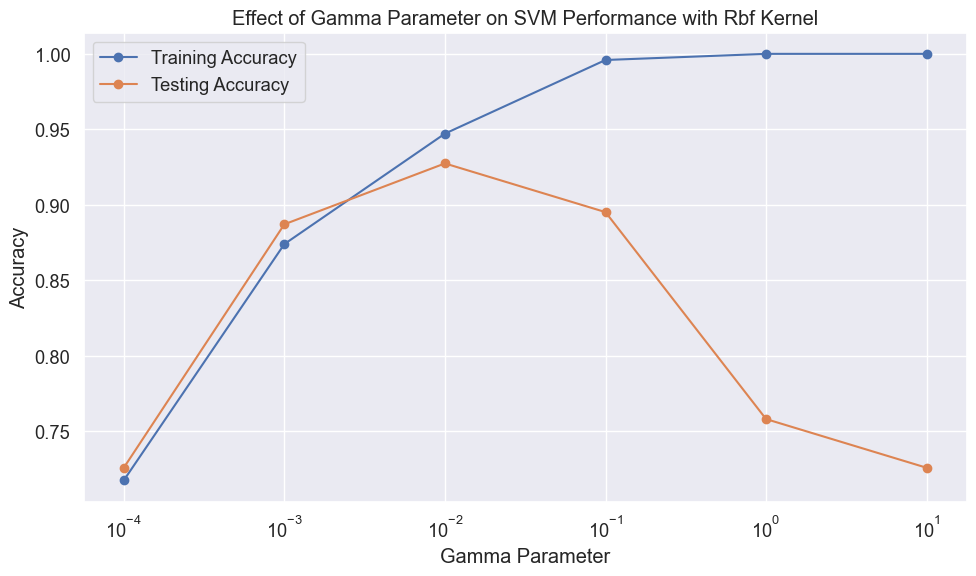

In [16]:
# Analyze gamma parameter effect (if using rbf kernel)
if best_kernel in ['rbf', 'poly', 'sigmoid']:
    gamma_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    gamma_accuracies_train = []
    gamma_accuracies_test = []
    
    for gamma in gamma_values:
        # Create and train model
        model = svm.SVC(kernel=best_kernel, C=grid_search.best_params_['C'], 
                      gamma=gamma, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Calculate and store accuracy scores
        train_accuracy = accuracy_score(y_train, model.predict(X_train_scaled))
        test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
        
        gamma_accuracies_train.append(train_accuracy)
        gamma_accuracies_test.append(test_accuracy)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.semilogx(gamma_values, gamma_accuracies_train, 'o-', label='Training Accuracy')
    plt.semilogx(gamma_values, gamma_accuracies_test, 'o-', label='Testing Accuracy')
    plt.xlabel('Gamma Parameter')
    plt.ylabel('Accuracy')
    plt.title(f'Effect of Gamma Parameter on SVM Performance with {best_kernel.capitalize()} Kernel')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

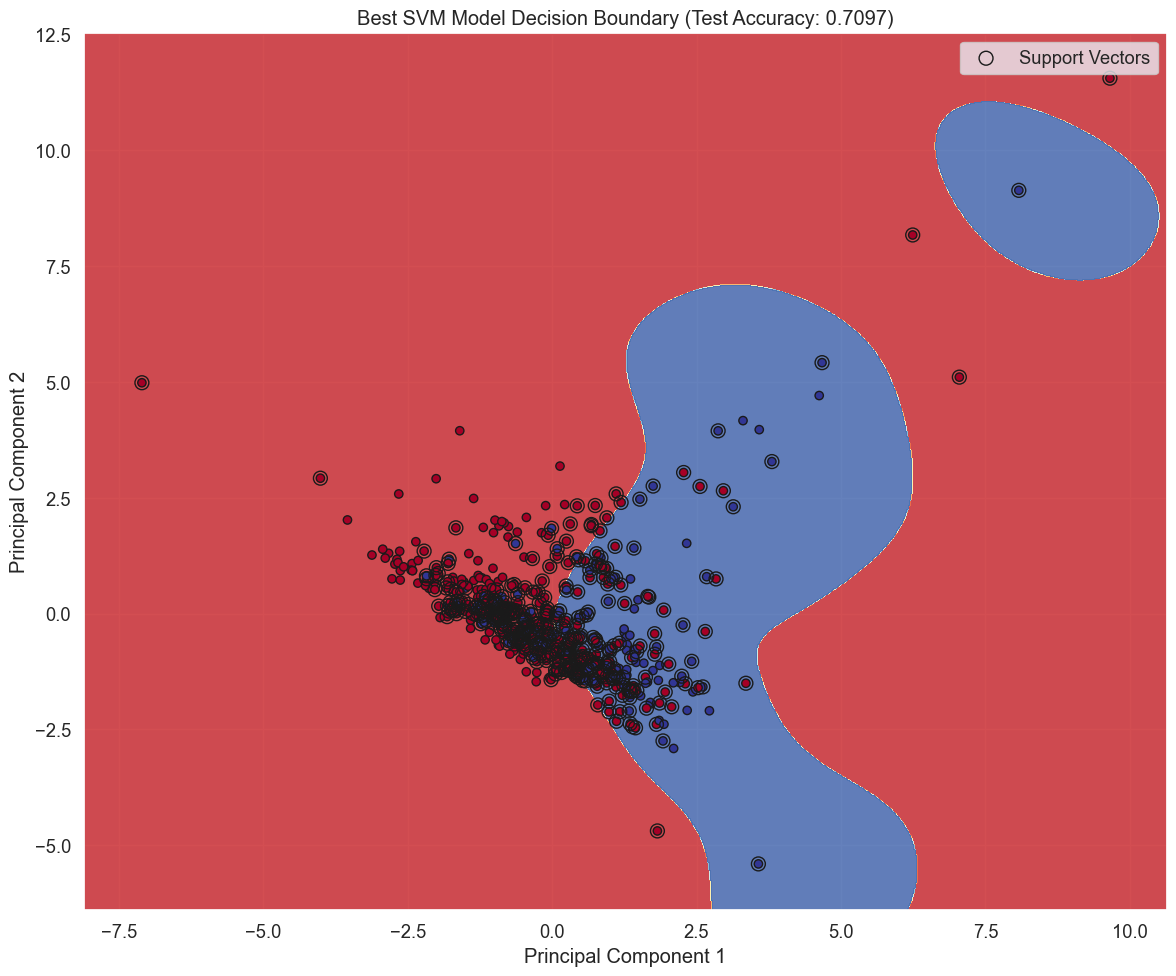

In [17]:
# 12. Decision Boundary Visualization of Best Model on PCA Components

# Create a new SVM with the best parameters and train on PCA data
best_svm_pca = svm.SVC(**grid_search.best_params_, random_state=42, class_weight='balanced')
best_svm_pca.fit(X_train_pca, y_train)

# Calculate accuracy on test set
test_pca_accuracy = accuracy_score(y_test, best_svm_pca.predict(X_test_pca))

# Plot decision boundary
plt.figure(figsize=(12, 10))

# Plot decision boundary
plot_decision_boundary(best_svm_pca, X_train_pca, y_train, 
                      title=f'Best SVM Model Decision Boundary (Test Accuracy: {test_pca_accuracy:.4f})')

# Highlight support vectors
support_vectors_pca = best_svm_pca.support_vectors_
plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], 
           s=100, linewidth=1, facecolors='none', edgecolors='k', 
           label='Support Vectors')
plt.legend()
plt.tight_layout()
plt.show()

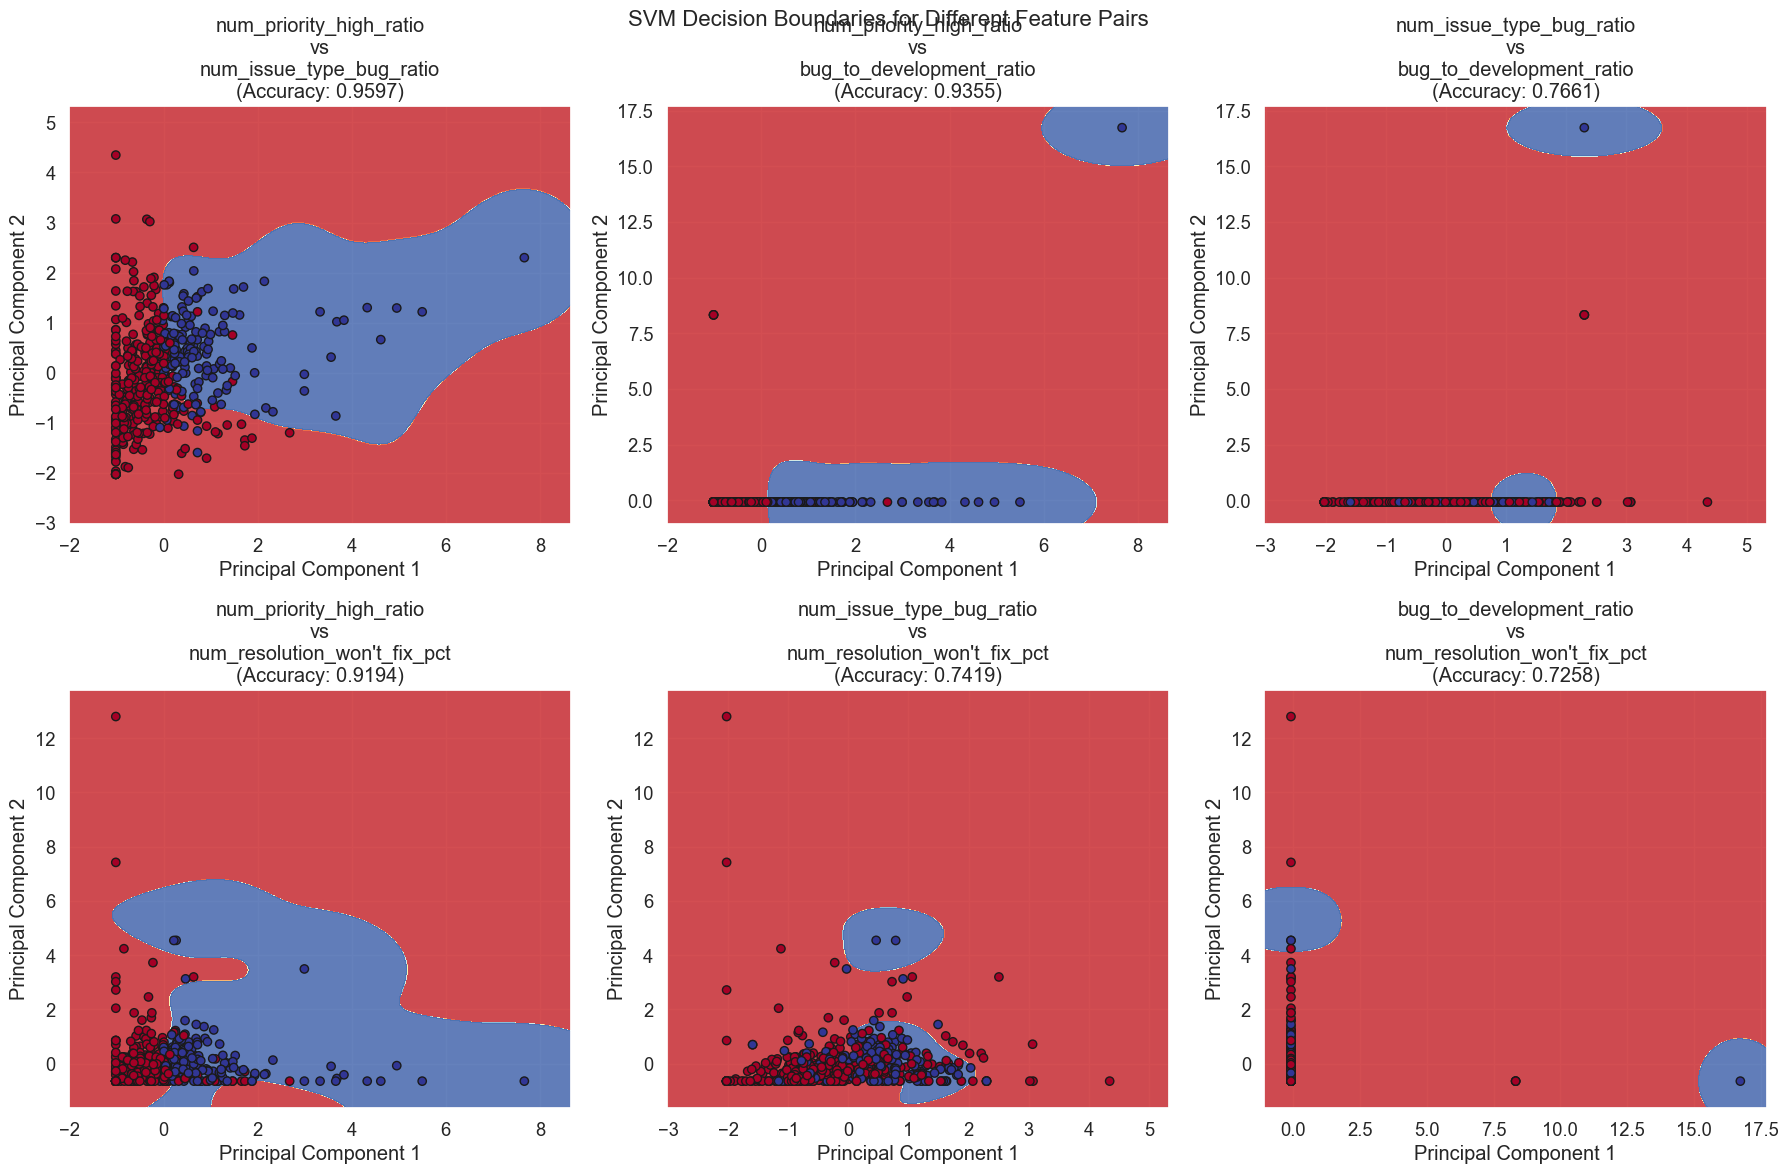

In [18]:
# 13. Decision Boundary on Original Features (for pairs of features)

# Create a 2x3 subplot grid to show different feature pairs
plt.figure(figsize=(18, 12))

# Define feature pairs to visualize
feature_pairs = [
    (0, 1),
    (0, 2),
    (1, 2),
    (0, 4),
    (1, 4),
    (2, 4)
]

for i, (f1, f2) in enumerate(feature_pairs):
    # Create a new SVM with the best parameters
    model = svm.SVC(**grid_search.best_params_, random_state=42)
    
    # Train on the selected feature pair
    X_train_pair = X_train_scaled[:, [f1, f2]]
    X_test_pair = X_test_scaled[:, [f1, f2]]
    model.fit(X_train_pair, y_train)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, model.predict(X_test_pair))
    
    # Plot the decision boundary
    plt.subplot(2, 3, i+1)
    plot_decision_boundary(model, X_train_pair, y_train,
                         title=f'{features[f1]}\nvs\n{features[f2]}\n(Accuracy: {accuracy:.4f})')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('SVM Decision Boundaries for Different Feature Pairs', fontsize=16)
plt.show()

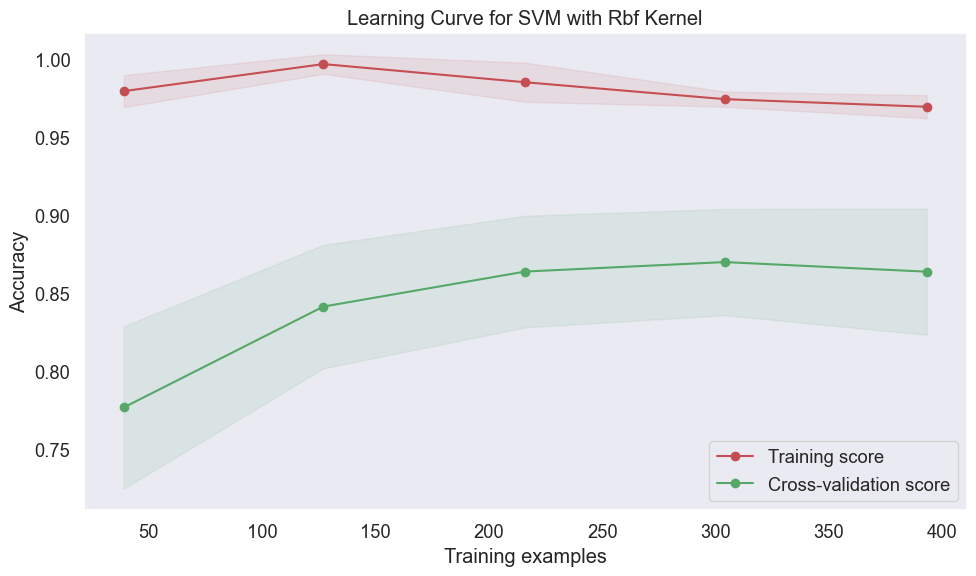

In [19]:
# 15. Learning Curve Analysis

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy")
    
    # Calculate mean and std
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.tight_layout()
    return plt

# Plot learning curve for the best SVM model
plot_learning_curve(best_svm_model, X_train_scaled, y_train, 
                  title=f"Learning Curve for SVM with {best_kernel.capitalize()} Kernel")
plt.show()

In [23]:
# 16. Model Persistence

# Create directory for models if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = f'models/{target}_svm_model.joblib'
joblib.dump(best_svm_model, model_filename)
print(f"\nModel saved to {model_filename}")

# Also save the scaler for future preprocessing
scaler_filename = f'models/{target}_svm_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

# Example of how to load the model and scaler
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)

# Test the loaded model
new_data = X_test  # Using test data as an example
new_data_scaled = loaded_scaler.transform(new_data)
predictions = loaded_model.predict(new_data_scaled)

print(f"Loaded model accuracy on test set: {accuracy_score(y_test, predictions):.4f}")


Model saved to models/quality_risk_svm_model.joblib
Scaler saved to models/quality_risk_svm_scaler.joblib
Loaded model accuracy on test set: 0.9355


In [10]:
target_names = ['Low Risk', 'High Risk']

In [11]:
# 18. Model Explainability with SHAP (SHapley Additive exPlanations)

# First, we need to install SHAP if it's not already installed
try:
    import shap
except ImportError:
    %pip install shap
    import shap

print("SHAP Analysis for Support Vector Machine Model")
print("============================================")

# Create a SHAP explainer for the SVM model
# Use the KernelExplainer since SVM is not a tree-based model
# We'll use a subset of training data as background for the explainer
X_train_summary = shap.kmeans(X_train_scaled, 10)  # Use KMeans to summarize the background data
explainer = shap.KernelExplainer(best_svm_model.decision_function, X_train_summary)

# Calculate SHAP values for a sample of test instances (for efficiency)
# For SVMs, this can be computationally intensive, so we use a sample
n_samples = min(20, len(X_test_scaled))  # Adjust based on computational resources
sampled_indices = np.random.choice(range(len(X_test_scaled)), n_samples, replace=False)
X_test_sample = X_test_scaled[sampled_indices]
y_test_sample = y_test[sampled_indices]

print(f"Computing SHAP values for {n_samples} test instances...")
shap_values = explainer.shap_values(X_test_sample)  # This may take some time

# Initialize JavaScript visualization
shap.initjs()

# Save the explainer data for later use
joblib.dump(explainer.data, f'models/{target}_svm_explainer_data.joblib')
print(f"SHAP explainer data saved to models/{target}_svm_explainer_data.joblib")

SHAP Analysis for Support Vector Machine Model
Computing SHAP values for 20 test instances...


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP explainer data saved to models/quality_risk_svm_explainer_data.joblib


In [24]:
shap_threshold = 0.05  # Set a threshold for significant SHAP values

C:\Users\phuon\AppData\Local\Temp\ipykernel_3908\1379902111.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(filtered_shap_values, filtered_X_test_sample, feature_names=selected_features,


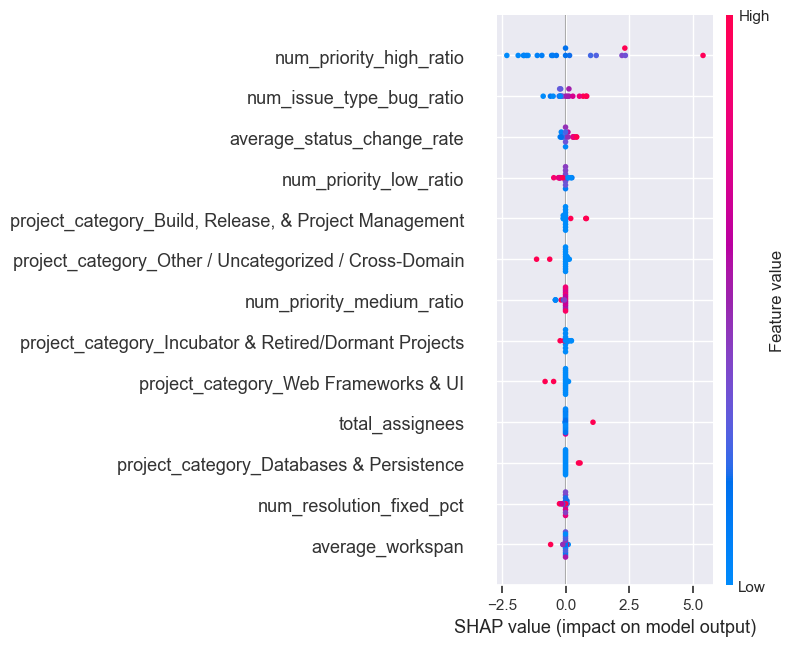

In [21]:
# For binary classification, we only care about the SHAP values for the positive class

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_names = X_train.columns

# Filter features above the threshold
selected_idx = np.where(mean_abs_shap >= shap_threshold)[0]
selected_features = feature_names[selected_idx]
filtered_shap_values = shap_values[:, selected_idx]
filtered_X_test_sample = X_test_sample[:, selected_idx]

# summary_plot for filtered features
shap.summary_plot(filtered_shap_values, filtered_X_test_sample, feature_names=selected_features, 
                  class_names=target_names, show=True)

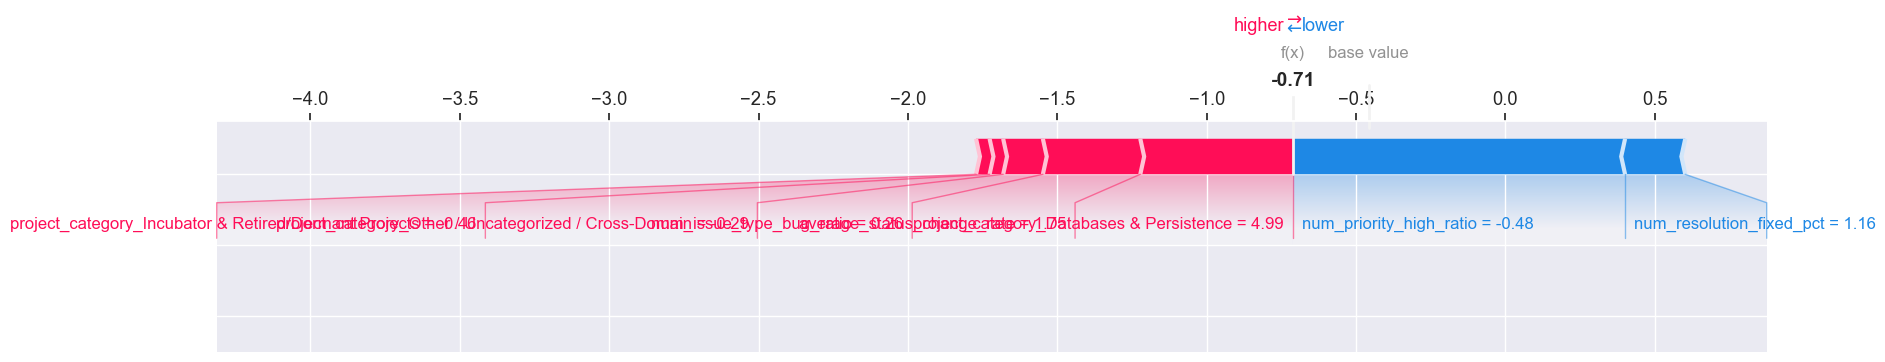

In [29]:
# force plot for the first instance in the test set, filtered by threshold and rounded to 2 decimals

# Calculate mean absolute SHAP values for each feature (for positive class)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
selected_idx = np.where(mean_abs_shap >= shap_threshold)[0]

# Filter SHAP values and features for the first instance
filtered_shap_values = shap_values[0, selected_idx]
filtered_feature_names = X_train.columns[selected_idx]
filtered_instance = X_test_sample[0, selected_idx].round(2)

# Create a force plot for the first instance
shap.force_plot(explainer.expected_value, filtered_shap_values, 
               filtered_instance, feature_names=filtered_feature_names, 
               matplotlib=True, show=True)

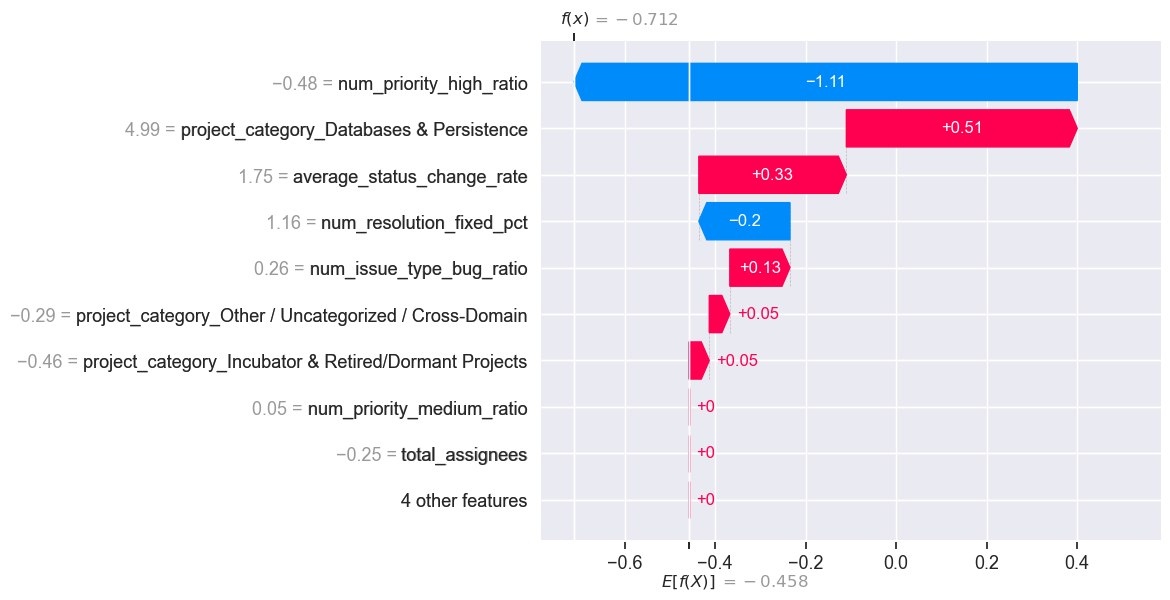

In [31]:
# waterfall plot for the first instance in the test set, filtered by threshold and rounded to 2 decimals
import shap

# Create a SHAP Explanation object for the first instance, positive class
explanation = shap.Explanation(
    values=filtered_shap_values,
    base_values=explainer.expected_value,
    data=filtered_instance,
    feature_names=filtered_feature_names
)

shap.waterfall_plot(explanation, max_display=10)